In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
import os

In [10]:
# Getting the display settings so that we can see all of the data
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)  

# Load Dataset
---

In [11]:
# loading the csv into a dataframe using pandas
crime_df = pd.read_csv('../data/crimedata2.csv',encoding='latin-1')

## Data Cleaning and Preparation
---

In [12]:
crime_df = crime_df.replace('?', np.nan)

In [13]:
# convert all columns to appropriate data types
for col in crime_df.drop(["state", "Êcommunityname", "countyCode", "communityCode"], axis=1).columns:
    if crime_df[col].dtype == "object":
        crime_df[col] = pd.to_numeric(crime_df[col], errors='coerce')

In [14]:
crime_df = crime_df.dropna(axis=1, how="all")

In [15]:
crime_df.head()

,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,1120

In [16]:
population_features  = ["population"]
crime_features       = [ "autoTheft", "autoTheftPerPop", "larcenies", "larcPerPop", "burglaries", "burglPerPop", "robberies", "robbbPerPop"]
money_features       = ["medIncome", "RentMedian", "MedRent"]
race_features        = ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
age_features         = ["agePct12t21", "agePct12t29", "agePct16t24", "agePct65up"]
categorical_features = ['Êcommunityname', 'state', 'countyCode', 'communityCode']
drop_list = [
    'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
    'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 
    'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
    'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
    'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 
    'LemasGangUnitDeploy', 'PolicBudgPerPop'
]


In [17]:
crime_df = crime_df.drop(drop_list, axis=1)

In [18]:
numerical_cols = crime_df.drop("fold", axis=1).select_dtypes(include=['float64', 'int64']).columns
crime_df[numerical_cols] = crime_df[numerical_cols].fillna(crime_df[numerical_cols].median())

In [19]:
crime_df.head()

,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,

In [20]:
# Add regions based on state
def assign_region(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
    southeast = ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA']
    midwest = ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MO', 'NE', 'ND', 'SD', 'MN']
    southwest = ['AZ', 'NM', 'OK', 'TX']
    west = ['CO', 'ID', 'MT', 'NV', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
    
    if state in northeast:
        return 'Northeast'
    elif state in southeast:
        return 'Southeast'
    elif state in midwest:
        return 'Midwest'
    elif state in southwest:
        return 'Southwest'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'

In [21]:
crime_df['region'] = crime_df['state'].apply(assign_region)

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\2047208763.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crime_df['region'] = crime_df['state'].apply(assign_region)


In [22]:
# Drop columns that are not useful for modeling
crime_df = crime_df.drop(columns=['state', 'Êcommunityname', 'countyCode', 'communityCode', "fold"])

In [23]:
# One-hot encode the regions column
crime_df['region'] = crime_df['region'].astype('category')
crime_df['region'] = crime_df['region'].cat.codes

In [24]:
# Detect and handle outliers (Optional)
# For simplicity, we'll cap outliers at the 1st and 99th percentiles
for col in numerical_cols:
    lower_cap = crime_df[col].quantile(0.01)
    upper_cap = crime_df[col].quantile(0.99)
    crime_df[col] = np.where(crime_df[col] < lower_cap, lower_cap, crime_df[col])
    crime_df[col] = np.where(crime_df[col] > upper_cap, upper_cap, crime_df[col])

## Bivariate Analysis
---

In [61]:
plt.rc('font', size=6)

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


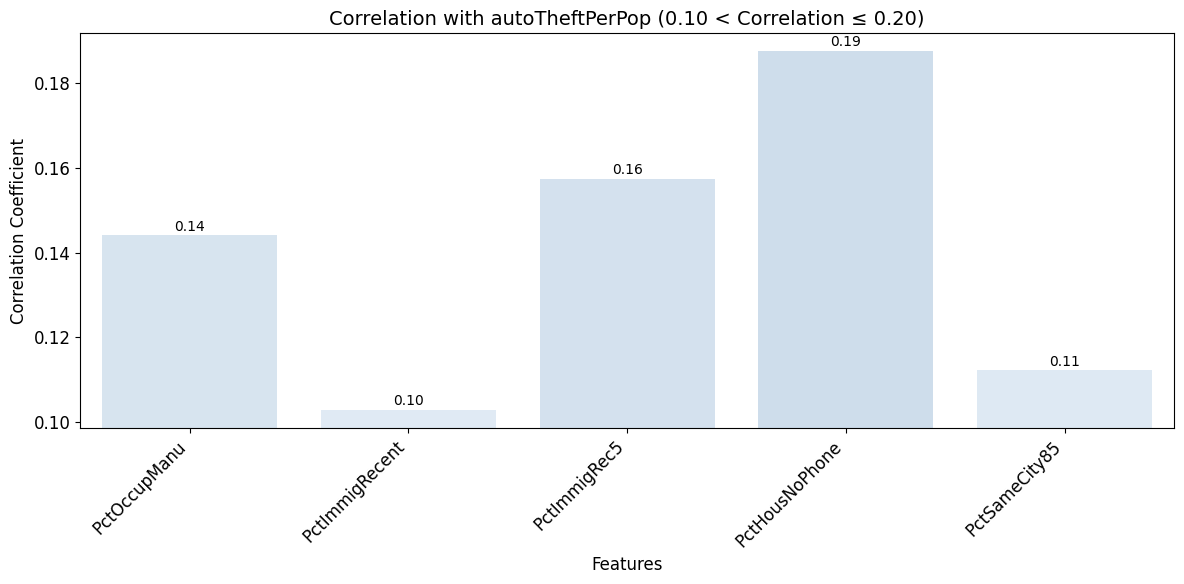

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


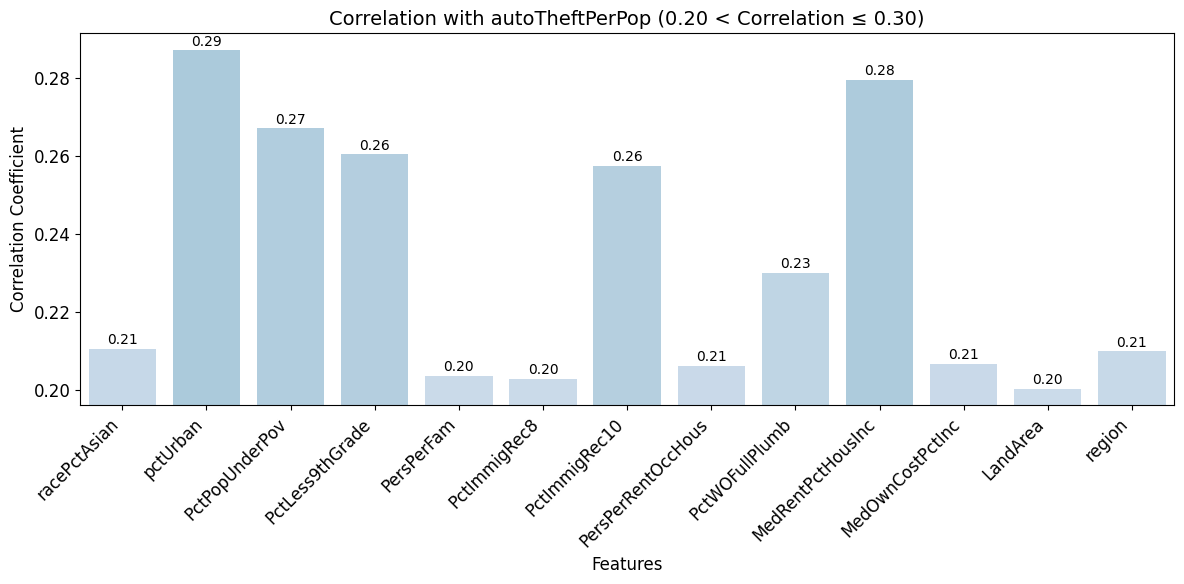

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


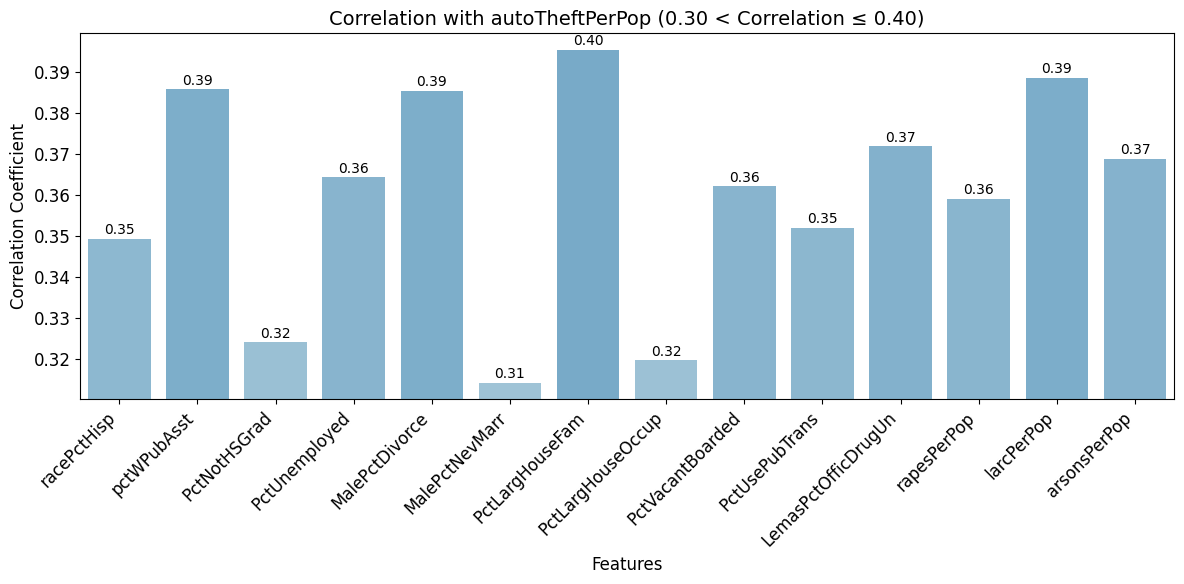

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


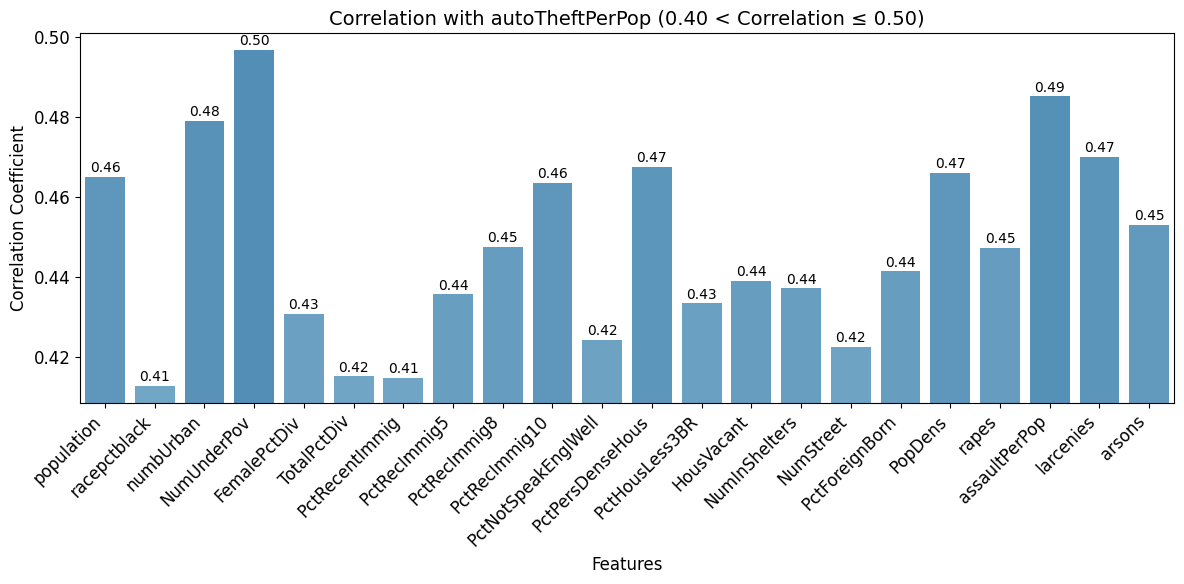

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


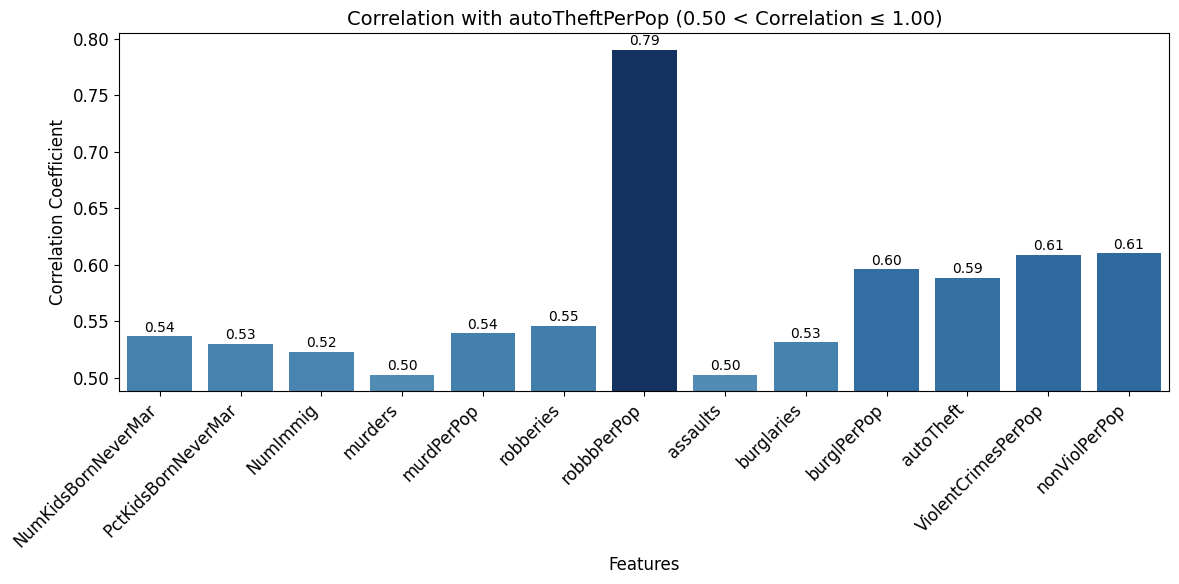

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


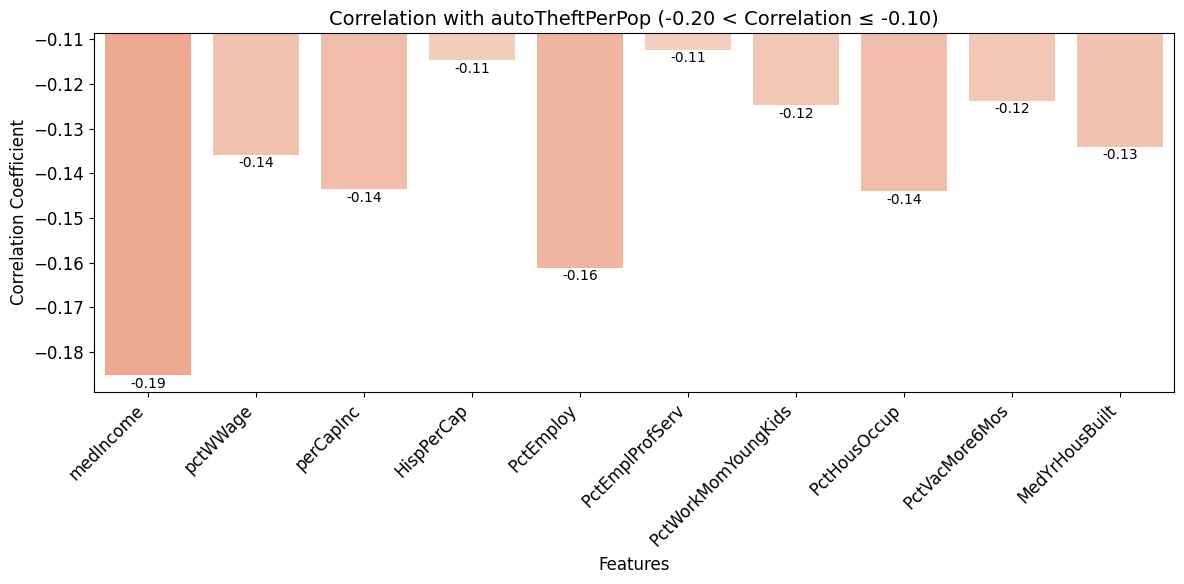

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


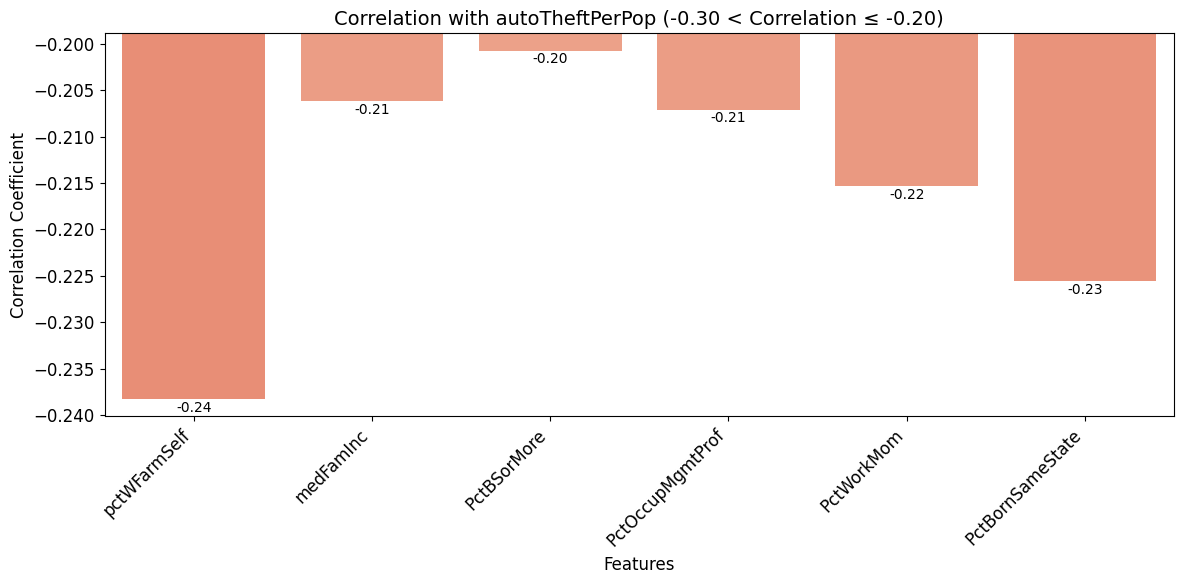

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


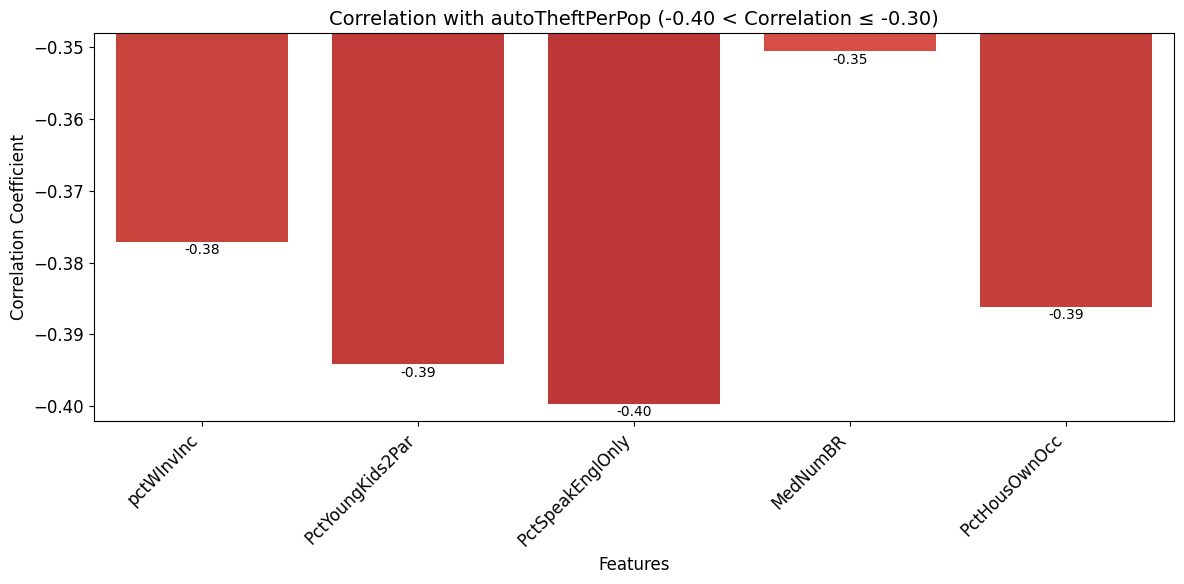

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


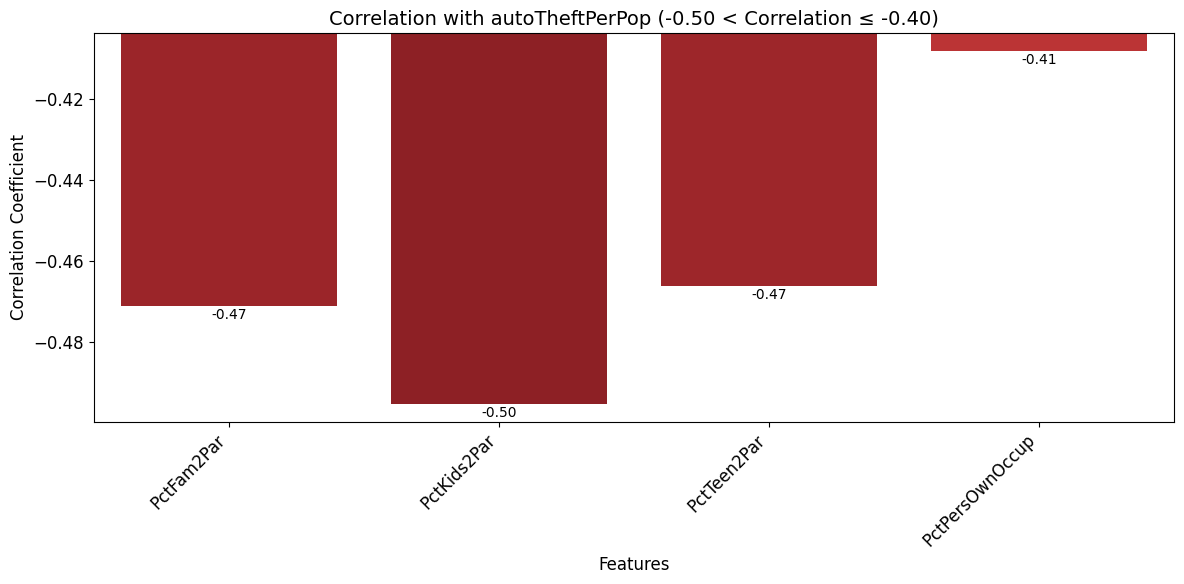

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1340041629.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)


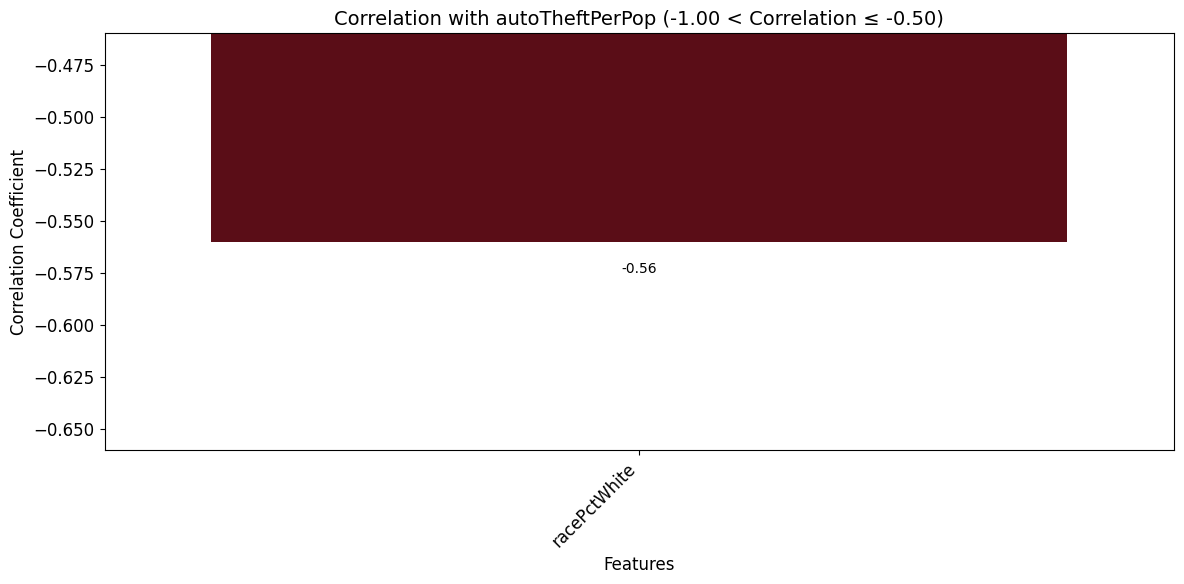

In [77]:
# Calculate correlations with 'autoTheftPerPop' excluding itself
correlations = crime_df.corr()['autoTheftPerPop'].drop('autoTheftPerPop')

# Define correlation ranges
ranges = [
    (0.10, 0.20), (0.20, 0.30), (0.30, 0.40), (0.40, 0.50), (0.50, 1.00),
    (-0.20, -0.10), (-0.30, -0.20), (-0.40, -0.30), (-0.50, -0.40), (-1.00, -0.50)
]

# Set global font size
plt.rc('font', size=12)

# Define separate colormaps for positive and negative correlations
cmap_positive = plt.get_cmap('Blues')
cmap_negative = plt.get_cmap('Reds')

# Determine the maximum positive and negative correlations for normalization
max_pos = correlations[correlations > 0].max()
max_neg = abs(correlations[correlations < 0].min())

for lower, upper in ranges:
    # Filter correlations within the current range
    range_correlations = correlations[(correlations > lower) & (correlations <= upper)]
    
    if not range_correlations.empty:
        plt.figure(figsize=(12, 6))
        
        # Assign colors based on the sign and magnitude of the correlation
        colors = []
        for value in range_correlations.values:
            if value > 0:
                # Normalize value between 0 and max_pos for positive correlations
                normalized = value / max_pos if max_pos != 0 else 0
                colors.append(cmap_positive(normalized))
            else:
                # Normalize value between 0 and max_neg for negative correlations
                normalized = abs(value) / max_neg if max_neg != 0 else 0
                colors.append(cmap_negative(normalized))
        
        # Create barplot with custom colors
        sns.barplot(x=range_correlations.index, y=range_correlations.values, palette=colors)
        
        # Set y-axis limits to provide space for labels
        min_corr = range_correlations.values.min()
        max_corr = range_correlations.values.max()
        y_margin = 0.05 * (max_corr - min_corr) if (max_corr - min_corr) != 0 else 0.1
        plt.ylim(min_corr - y_margin, max_corr + y_margin)
        
        # Annotate each bar with the correlation value
        for i, value in enumerate(range_correlations.values):
            if value >= 0:
                # Positive correlation: place text slightly above the bar
                plt.text(i, value + y_margin * 0.1, f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')
            else:
                # Negative correlation: place text slightly below the bar
                plt.text(i, value - y_margin * 0.1, f'{value:.2f}', ha='center', va='top', fontsize=10, color='black')
        
        # Set title and labels
        plt.title(f'Correlation with autoTheftPerPop ({lower:.2f} < Correlation ≤ {upper:.2f})', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()


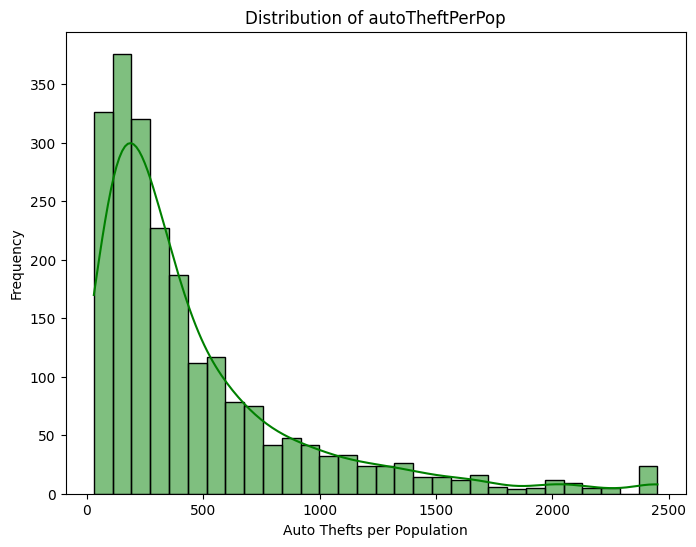

In [26]:
# Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.histplot(crime_df['autoTheftPerPop'], kde=True, bins=30, color='green')
plt.title('Distribution of autoTheftPerPop')
plt.xlabel('Auto Thefts per Population')
plt.ylabel('Frequency')
plt.show()

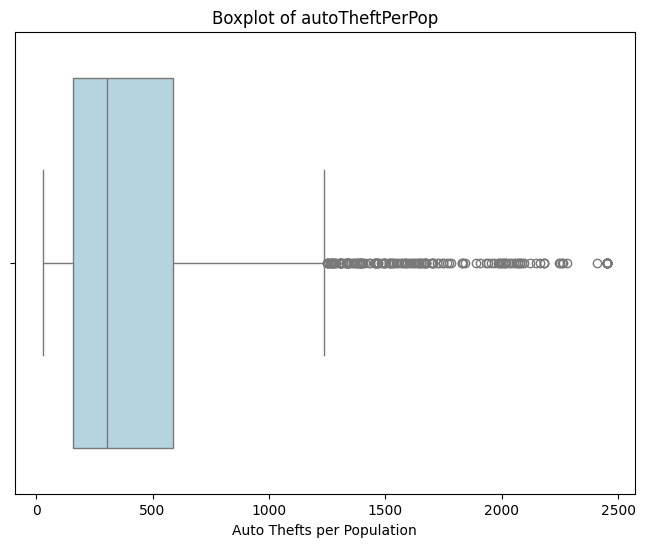

In [27]:
# Boxplot to identify outliers in target variable
plt.figure(figsize=(8, 6))
sns.boxplot(x=crime_df['autoTheftPerPop'], color='lightblue')
plt.title('Boxplot of autoTheftPerPop')
plt.xlabel('Auto Thefts per Population')
plt.show()

In [28]:
def plot_barplot(dataframe:pd.DataFrame, x:str, y:str=None, title:str=None, by:str=None, errorbar: tuple|bool=None, xtick_rotation:int=0, figsize:tuple=(12, 7)):
    plt.figure(figsize=figsize)
    sns.barplot(
        data=dataframe,
        x=x,
        y=y,
        hue=by,
        errorbar=errorbar
    )
    plt.title(title)
    plt.xlabel(x)
    if y != None:
        plt.ylabel(y)
    plt.xticks(rotation=xtick_rotation)
    plt.show()

### Auto theft vs State

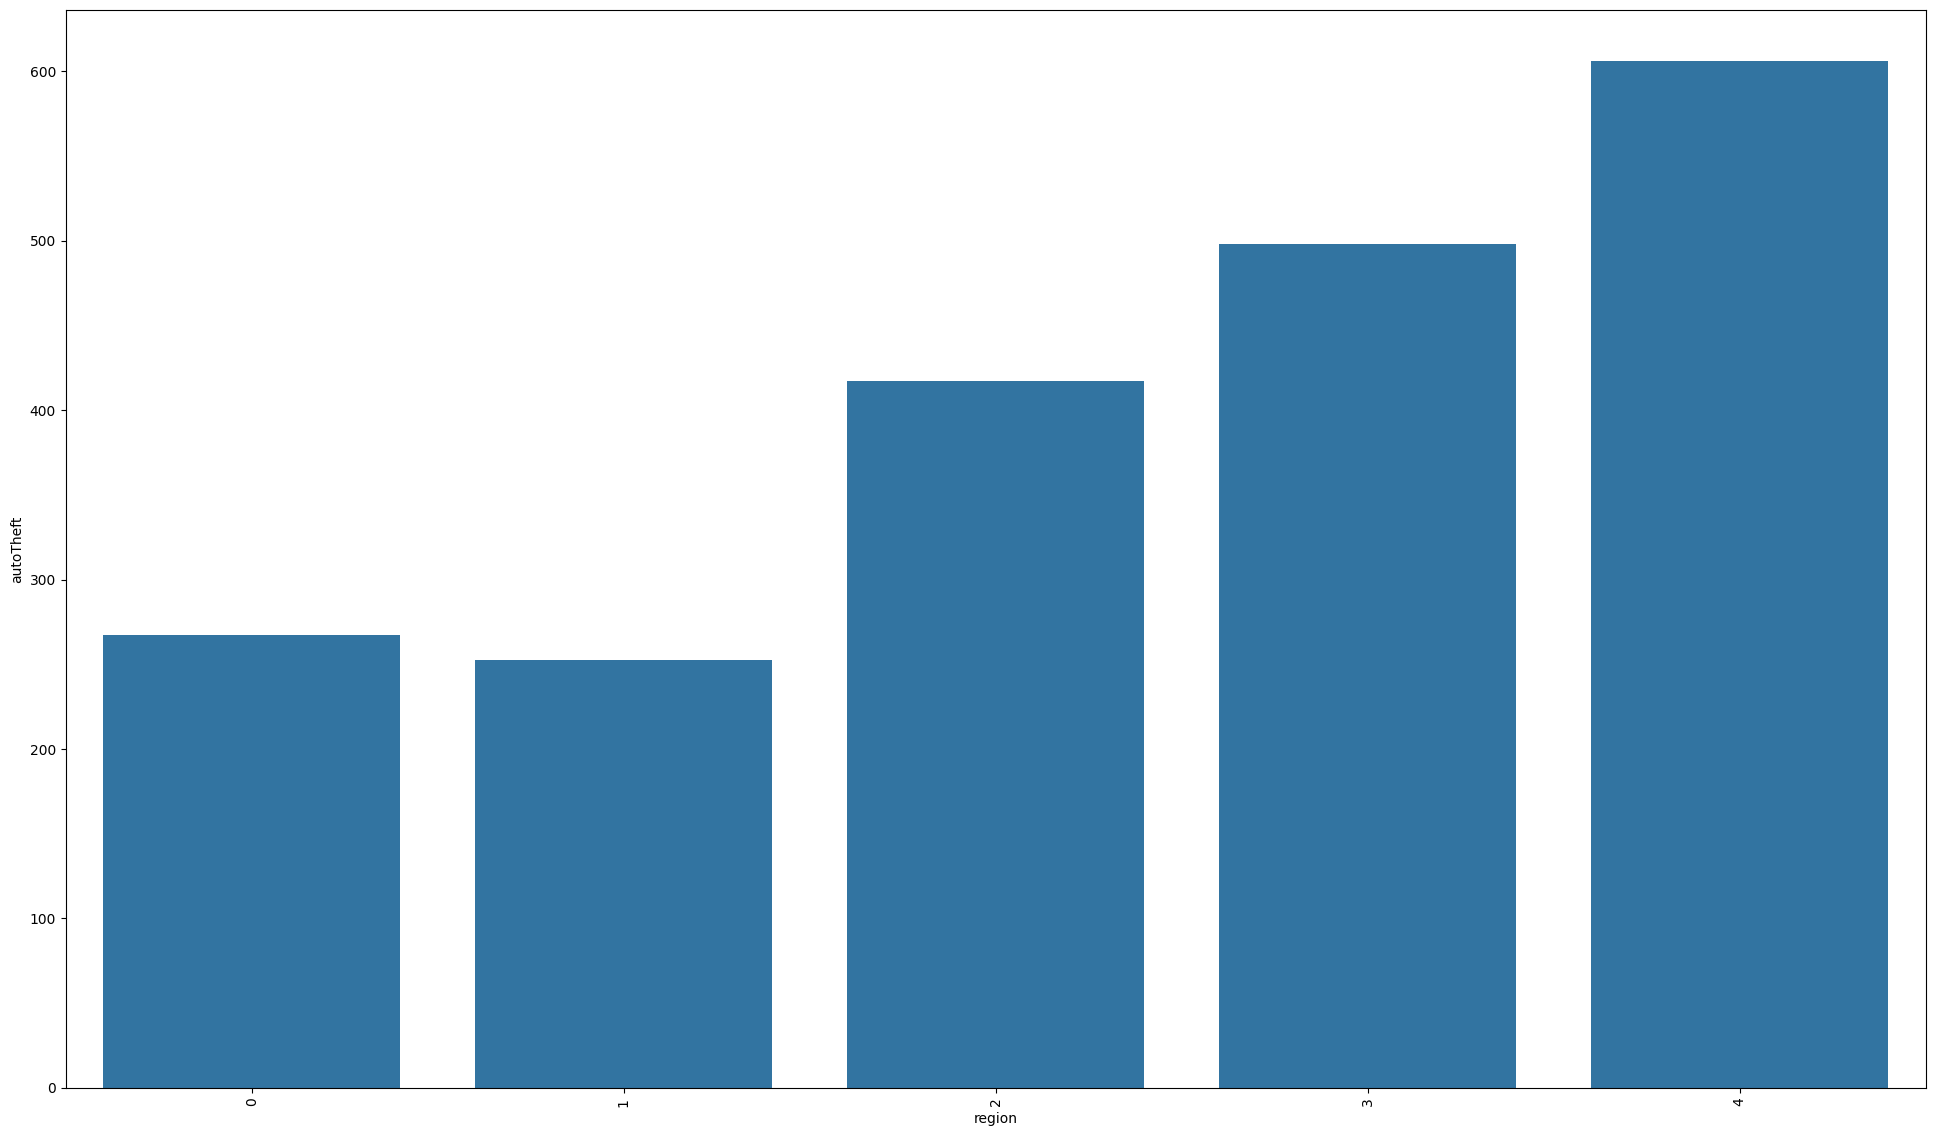

In [29]:
plot_barplot(dataframe=crime_df, x="region", y="autoTheft", xtick_rotation=90, figsize=(24, 14))

In [ ]:
plot_barplot(dataframe=crime_df, x="region", y="larcenies", xtick_rotation=90, figsize=(24, 14))

In [ ]:
plot_barplot(dataframe=crime_df, x="region", y="larcenies", xtick_rotation=90, figsize=(24, 14))

- The West seems to have the most auto thefts in the US.

In [30]:
def multiple_barplots(dataframe:pd.DataFrame, x:str|list, y:str|list[str],  title:str=None, n_rows:int=1, n_cols:int=1, figsize:tuple=(9, 4), xtick_rotation:int=0, sharex:bool=True, sharey:bool=True, errorbar:tuple|bool=None)->None:
    fig, ax = plt.subplots(n_rows, n_cols, sharex=sharex, sharey=sharey, figsize=figsize)
    col_index = 0

    if n_rows>1 and n_cols>1:
        for i in range(n_rows):
            for j in range(n_cols):
                ax[i][j] = sns.barplot(data=dataframe, x=x, y=y[col_index], ax=ax[i][j], errorbar=errorbar)
                ax[i][j].tick_params(rotation=xtick_rotation)
                ax[i][j].set_title(f"{y[col_index]} vs {x}")
                ax[i][j].set(ylabel=None, xlabel=None)
                col_index += 1
    elif n_cols > 1:
        for j in range(n_cols):
            ax[j] = sns.barplot(data=dataframe, x=x, y=y[col_index], ax=ax[j], errorbar=errorbar)
            ax[j].tick_params(rotation=xtick_rotation)
            ax[j].set_title(f"{y[col_index]} vs {x}")
            ax[j].set(ylabel=None, xlabel=None)
            col_index += 1
    fig.suptitle(title)
    plt.tight_layout()
    fig.show()

In [31]:
plt.rcParams.update({'font.size': 18})

In [32]:
all_sum = crime_df[["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]].sum().sum()
black_proportion = crime_df["racepctblack"].sum()/all_sum
white_proportion = crime_df["racePctWhite"].sum()/all_sum
hispanic_proportion = crime_df["racePctHisp"].sum()/all_sum
asian_proportion = crime_df["racePctAsian"].sum()/all_sum
print(f"Black proportion: {black_proportion*100}")
print(f"White proportion: {white_proportion*100}")
print(f"Hispanic proportion: {hispanic_proportion*100}")
print(f"Asian proportion: {asian_proportion*100}")

Black proportion: 8.89294799558765
White proportion: 81.04826136993599
Hispanic proportion: 7.581648817664679
Asian proportion: 2.477141816811695


* PctUnemployed: Percentage of unemployed individuals (numeric)
* PctEmploy: Percentage of employed individuals (numeric)
* PctEmplManu: Percentage of people employed in manufacturing (numeric)
* PctEmplProfServ: Percentage of people employed in professional services (numeric)

* pctWWage: Percentage of households with wage/salary income in 1989 (numeric)
* pctWFarmSelf: Percentage of households with farm or self-employment income in 1989 (numeric)
* pctWInvInc: Percentage of households with investment income (numeric)
* pctWSocSec: Percentage of households with social security income (numeric)
* pctWPubAsst: Percentage of households with public assistance (numeric)
* pctWRetire: Percentage of households with retirement income (numeric)

* PctImmigRecent: Percentage of recent immigrants (within 3 years) (numeric)
* PctImmigRec5: Percentage of immigrants within the last 5 years (numeric)
* PctImmigRec8: Percentage of immigrants within the last 8 years (numeric)
* PctImmigRec10: Percentage of immigrants within the last 10 years (numeric)
* PctRecentImmig: Percentage of recent immigrants in the population (numeric)
* PctRecImmig5: Percentage of population who immigrated within the last 5 years (numeric)
* PctRecImmig8: Percentage of population who immigrated within the last 8 years (numeric)
* PctRecImmig10: Percentage of population who immigrated within the last 10 years (numeric)

* medIncome: Median household income (numeric)
* medFamInc: Median family income (numeric)

## Graph Correlation with Scatterplot
---

In [33]:
def linear_relationship_plot(dataframe: pd.DataFrame, x:str, y:list, title:str, ci:bool=False, n_rows:int=1, n_cols:int=1, sharex=True, sharey=True, xtick_rotation:int=0, figsize:tuple=(28, 14)) :
    fig, ax = plt.subplots(n_rows, n_cols, sharex=sharex, sharey=sharey, figsize=figsize)
    col_index = 0

    if n_rows>1 and n_cols>1:
        for i in range(n_rows):
            for j in range(n_cols):
                ax[i][j] = sns.regplot(data=dataframe, x=x, y=y[col_index], ax=ax[i][j], ci=ci, line_kws={"color":"red"})
                ax[i][j].tick_params(rotation=xtick_rotation)
                ax[i][j].set_title(f"{y[col_index]} vs {x}")
                ax[i][j].set(ylabel=None, xlabel=None)
                col_index += 1
    elif n_cols > 1:
        for j in range(n_cols):
            ax[j] = sns.regplot(data=dataframe, x=x, y=y[col_index], ax=ax[j], ci=ci, line_kws={"color":"red"})
            ax[j].tick_params(rotation=xtick_rotation)
            ax[j].set_title(f"{y[col_index]} vs {x}")
            ax[j].set(ylabel=None, xlabel=None)
            col_index += 1
    fig.suptitle(title)
    plt.tight_layout()
    fig.show()

In [34]:
plt.rcParams.update({"font.size":21})

C:\Users\riain\AppData\Local\Temp\ipykernel_30788\1068752479.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


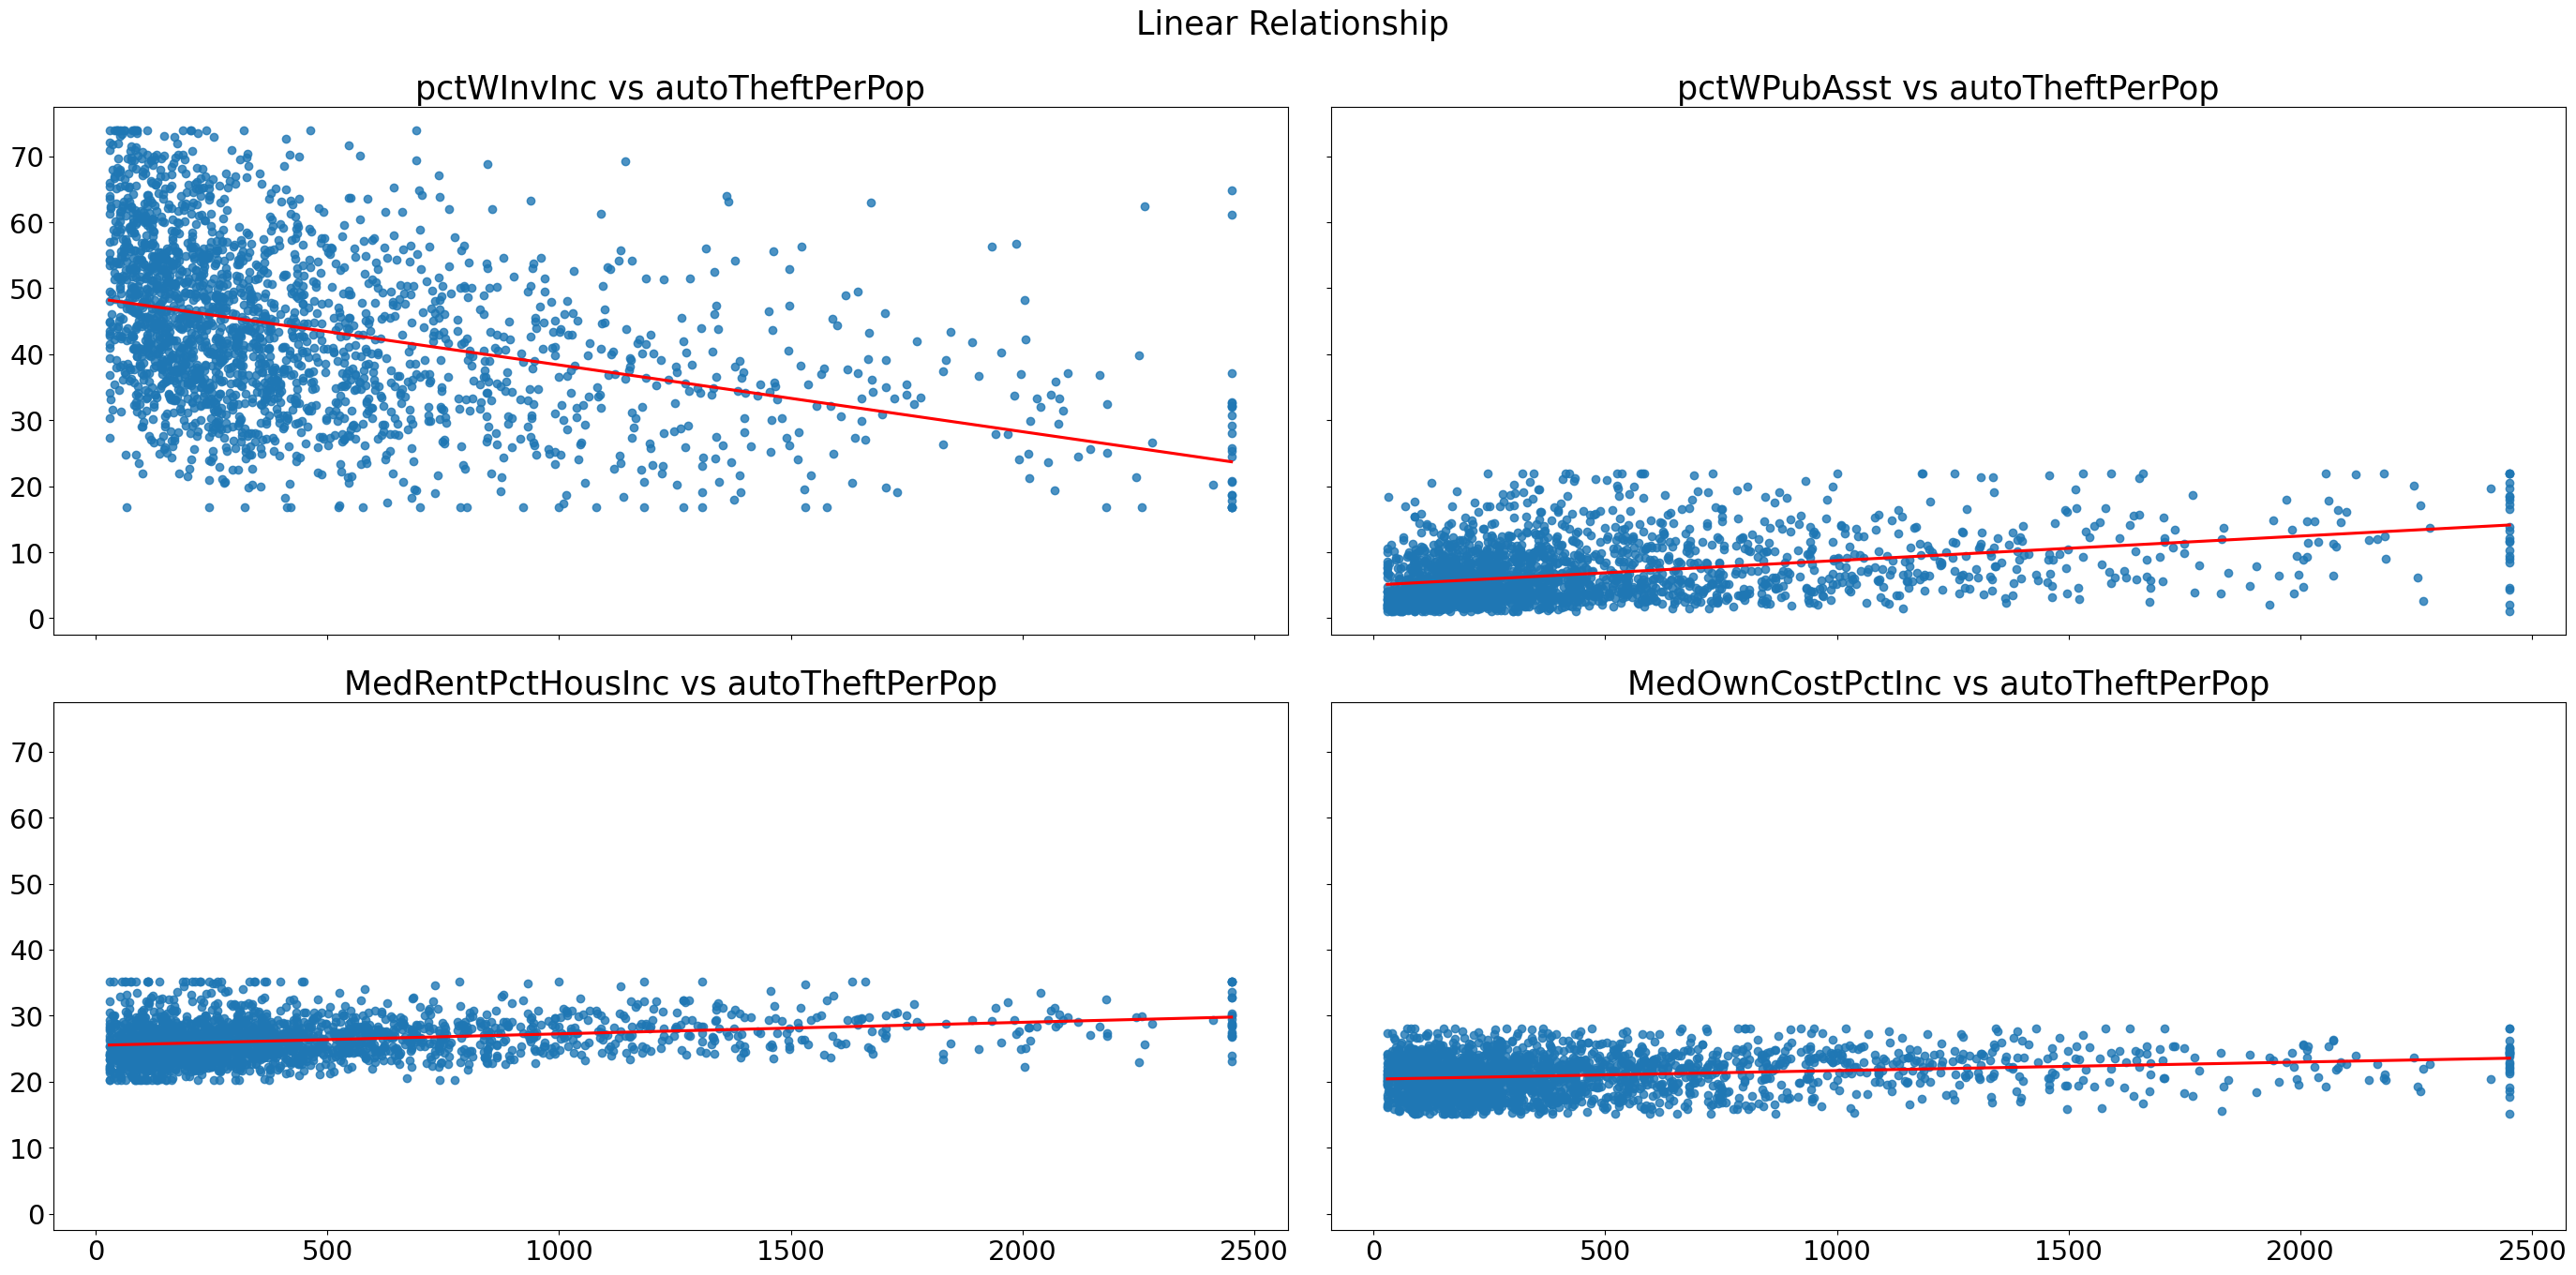

In [35]:
linear_relationship_plot(
    dataframe=crime_df,
    x="autoTheftPerPop",
    y=["pctWInvInc", "pctWPubAsst", "MedRentPctHousInc", "MedOwnCostPctInc"],
    title="Linear Relationship",
    n_rows=2,
    n_cols=2
)

## Baseline Model
---

In [36]:
# Split data into predictors and target
features = crime_df.drop(columns=['autoTheftPerPop'])
X = features
y = crime_df['autoTheftPerPop']

In [37]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Standardize data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Baseline Model: Mean of Target as Prediction
y_pred_baseline = np.full(y_test.shape, y_train.mean())
y_train_pred_baseline = np.full(y_train.shape, y_train.mean())

In [40]:
# Evaluate Baseline Model
r2_baseline_train = r2_score(y_train, y_train_pred_baseline)
r2_baseline_test = r2_score(y_test, y_pred_baseline)
mse_baseline_train = root_mean_squared_error(y_train, y_train_pred_baseline)**2
mse_baseline_test = root_mean_squared_error(y_test, y_pred_baseline)**2
rmse_baseline_train = np.sqrt(mse_baseline_train)
rmse_baseline_test = np.sqrt(mse_baseline_test)

In [41]:
print("Baseline Model Evaluation:")
print(f"  Train R2: {r2_baseline_train:.4f}")
print(f"  Test R2: {r2_baseline_test:.4f}")
print(f"  Train MSE: {mse_baseline_train:.4f}")
print(f"  Test MSE: {mse_baseline_test:.4f}")
print(f"  Train RMSE: {rmse_baseline_train:.4f}")
print(f"  Test RMSE: {rmse_baseline_test:.4f}\n")

Baseline Model Evaluation:
  Train R2: 0.0000
  Test R2: -0.0009
  Train MSE: 216850.6145
  Test MSE: 240170.1454
  Train RMSE: 465.6722
  Test RMSE: 490.0716



In [42]:
# Function to evaluate regression models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = root_mean_squared_error(y_train, y_train_pred)**2
    mse_test = root_mean_squared_error(y_test, y_test_pred)**2
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    # Print evaluation
    print(f"{model_name} Evaluation:")
    print(f"  Train R²: {r2_train:.4f}")
    print(f"  Test R²: {r2_test:.4f}")
    print(f"  Train MSE: {mse_train:.4f}")
    print(f"  Test MSE: {mse_test:.4f}")
    print(f"  Train RMSE: {rmse_train:.4f}")
    print(f"  Test RMSE: {rmse_test:.4f}\n")
    
    return {
        'Model': model_name,
        'R2_Test': r2_test,
        'MSE_Test': mse_test,
        'RMSE_Test': rmse_test,
        'y_test_pred': y_test_pred
    }

In [ ]:
# Initialize list to store model evaluations
model_evaluations = []

# 1. CART Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42, max_leaf_nodes=5)
dt_results = evaluate_regression_model(dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")
model_evaluations.append(dt_results)

# 2. Random Forest Regressor Model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_results = evaluate_regression_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")
model_evaluations.append(rf_results)

# 3. Gradient Boosting Regressor Model (Added for completeness)
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_results = evaluate_regression_model(gbm_model, X_train_scaled, y_train, X_test_scaled, y_test, "Gradient Boosting")
model_evaluations.append(gbm_results)

# 4. XGBoost Regressor Model (Added for completeness)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_results = evaluate_regression_model(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")
model_evaluations.append(xgb_results)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'R²': [r2_baseline_test, dt_results['R2_Test'], rf_results['R2_Test'], gbm_results['R2_Test'], xgb_results['R2_Test']],
    'MSE': [mse_baseline_test, dt_results['MSE_Test'], rf_results['MSE_Test'], gbm_results['MSE_Test'], xgb_results['MSE_Test']],
    'RMSE': [rmse_baseline_test, dt_results['RMSE_Test'], rf_results['RMSE_Test'], gbm_results['RMSE_Test'], xgb_results['RMSE_Test']]
})

Decision Tree Evaluation:
  Train R²: 1.0000
  Test R²: 0.8330
  Train MSE: 0.0000
  Test MSE: 40075.7874
  Train RMSE: 0.0000
  Test RMSE: 200.1894

Random Forest Evaluation:
  Train R²: 0.9865
  Test R²: 0.9058
  Train MSE: 2933.0388
  Test MSE: 22603.2700
  Train RMSE: 54.1575
  Test RMSE: 150.3438

Gradient Boosting Evaluation:
  Train R²: 0.9864
  Test R²: 0.9329
  Train MSE: 2945.8484
  Test MSE: 16093.0879
  Train RMSE: 54.2757
  Test RMSE: 126.8585

XGBoost Evaluation:
  Train R²: 1.0000
  Test R²: 0.9231
  Train MSE: 0.8159
  Test MSE: 18461.0680
  Train RMSE: 0.9033
  Test RMSE: 135.8715



In [44]:
comparison_df

,Model,R²,MSE,RMSE
0,Baseline,-0.000851,240170.145374,490.071572
1,Decision Tree,0.832994,40075.787366,200.189379
2,Random Forest,0.905806,22603.269986,150.343839
3,Gradient Boosting,0.932936,16093.087911,126.858535
4,XGBoost,0.923068,18461.067991,135.871513


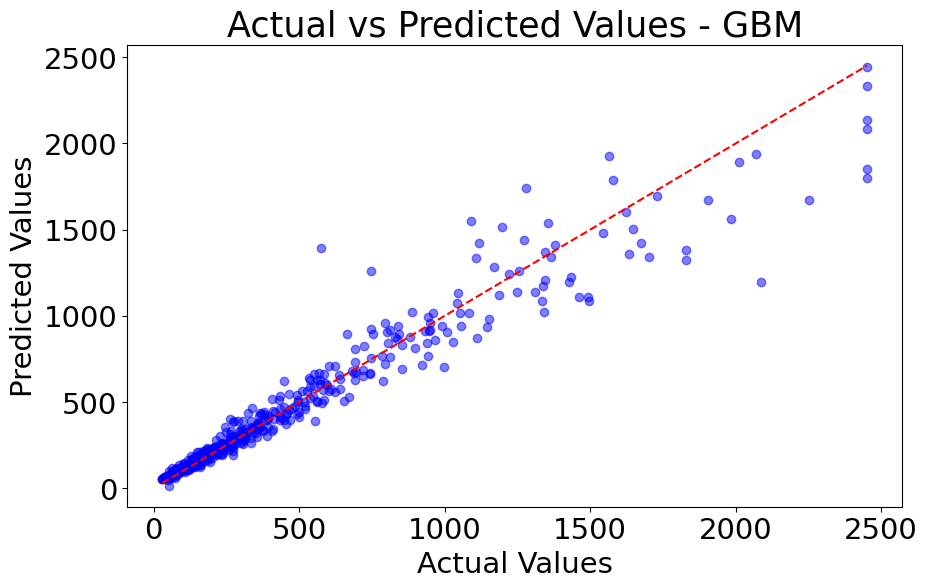

In [45]:
# Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbm_results['y_test_pred'], alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Values - GBM')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [46]:
# Encode target variable for classification (e.g., high vs. low auto theft rate)
# Define a threshold, e.g., median value
threshold = y.median()
y_class = np.where(y > threshold, 1, 0)

# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Standardize features for classification models
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

In [47]:
# Initialize model
linear_model = LinearRegression()

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_r2 = cross_val_score(linear_model, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse = -cross_val_score(linear_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Multiple Linear Regression Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2}")
print(f"  Average R²: {cv_scores_r2.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse}")
print(f"  Average MSE: {cv_scores_mse.mean():.4f}\n")

# Fit and evaluate on test set
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = root_mean_squared_error(y_test, y_pred_linear)**2
rmse_linear = np.sqrt(mse_linear)

print("Multiple Linear Regression Test Set Evaluation:")
print(f"  R²: {r2_linear:.4f}")
print(f"  MSE: {mse_linear:.4f}")
print(f"  RMSE: {rmse_linear:.4f}\n")

Multiple Linear Regression Cross-Validation Results:
  R² Scores: [0.7314016  0.83731892 0.79989786 0.85093561 0.83423309]
  Average R²: 0.8108
  MSE Scores: [53309.57881544 44073.97922816 46442.85280627 25186.93659775
 35004.1540252 ]
  Average MSE: 40803.5003

Multiple Linear Regression Test Set Evaluation:
  R²: 0.8245
  MSE: 42102.8323
  RMSE: 205.1897



In [48]:
from sklearn.linear_model import LogisticRegression

# Initialize model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Perform 5-fold cross-validation
cv_scores_accuracy = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1 = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc = cross_val_score(logistic_model, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Multiple Logistic Regression Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy.mean():.4f}")
print(f"  Precision: {cv_scores_precision.mean():.4f}")
print(f"  Recall: {cv_scores_recall.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc.mean():.4f}\n")

# Fit and evaluate on test set
logistic_model.fit(X_train_clf_scaled, y_train_clf)
y_pred_logistic = logistic_model.predict(X_test_clf_scaled)
y_pred_logistic_proba = logistic_model.predict_proba(X_test_clf_scaled)[:,1]

accuracy_logistic = accuracy_score(y_test_clf, y_pred_logistic)
precision_logistic = precision_score(y_test_clf, y_pred_logistic)
recall_logistic = recall_score(y_test_clf, y_pred_logistic)
f1_logistic = f1_score(y_test_clf, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test_clf, y_pred_logistic_proba)

print("Multiple Logistic Regression Test Set Evaluation:")
print(f"  Accuracy: {accuracy_logistic:.4f}")
print(f"  Precision: {precision_logistic:.4f}")
print(f"  Recall: {recall_logistic:.4f}")
print(f"  F1-Score: {f1_logistic:.4f}")
print(f"  ROC-AUC: {roc_auc_logistic:.4f}\n")

Multiple Logistic Regression Cross-Validation Results:
  Accuracy: 0.8674
  Precision: 0.8816
  Recall: 0.8517
  F1-Score: 0.8659
  ROC-AUC: 0.9474

Multiple Logistic Regression Test Set Evaluation:
  Accuracy: 0.8849
  Precision: 0.8932
  Recall: 0.8638
  F1-Score: 0.8783
  ROC-AUC: 0.9495



In [49]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Regression Task
dt_regressor = DecisionTreeRegressor(random_state=42)
cv_scores_r2_dt = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_dt = -cross_val_score(dt_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Decision Tree Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_dt}")
print(f"  Average R²: {cv_scores_r2_dt.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_dt}")
print(f"  Average MSE: {cv_scores_mse_dt.mean():.4f}\n")

# Fit and evaluate on test set
dt_regressor.fit(X_train_scaled, y_train)
y_pred_dt = dt_regressor.predict(X_test_scaled)
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = root_mean_squared_error(y_test, y_pred_dt)**2
rmse_dt = np.sqrt(mse_dt)

print("Decision Tree Regressor Test Set Evaluation:")
print(f"  R²: {r2_dt:.4f}")
print(f"  MSE: {mse_dt:.4f}")
print(f"  RMSE: {rmse_dt:.4f}\n")

# Classification Task (Optional)
dt_classifier = DecisionTreeClassifier(random_state=42)
cv_scores_accuracy_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_dt = cross_val_score(dt_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Decision Tree Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_dt.mean():.4f}")
print(f"  Precision: {cv_scores_precision_dt.mean():.4f}")
print(f"  Recall: {cv_scores_recall_dt.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_dt.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_dt.mean():.4f}\n")

# Fit and evaluate on test set
dt_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_dt_clf = dt_classifier.predict(X_test_clf_scaled)
y_pred_dt_proba_clf = dt_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_dt = accuracy_score(y_test_clf, y_pred_dt_clf)
precision_dt = precision_score(y_test_clf, y_pred_dt_clf)
recall_dt = recall_score(y_test_clf, y_pred_dt_clf)
f1_dt = f1_score(y_test_clf, y_pred_dt_clf)
roc_auc_dt = roc_auc_score(y_test_clf, y_pred_dt_proba_clf)

print("Decision Tree Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall: {recall_dt:.4f}")
print(f"  F1-Score: {f1_dt:.4f}")
print(f"  ROC-AUC: {roc_auc_dt:.4f}\n")

Decision Tree Regressor Cross-Validation Results:
  R² Scores: [0.79247135 0.771723   0.82965338 0.8107537  0.78349047]
  Average R²: 0.7976
  MSE Scores: [41188.87194813 61845.39799684 39536.72377038 31976.34468017
 45719.21434303]
  Average MSE: 44053.3105

Decision Tree Regressor Test Set Evaluation:
  R²: 0.8330
  MSE: 40075.7874
  RMSE: 200.1894

Decision Tree Classifier Cross-Validation Results:
  Accuracy: 0.9012
  Precision: 0.9151
  Recall: 0.8869
  F1-Score: 0.9007
  ROC-AUC: 0.9012

Decision Tree Classifier Test Set Evaluation:
  Accuracy: 0.9097
  Precision: 0.8844
  Recall: 0.9343
  F1-Score: 0.9087
  ROC-AUC: 0.9106



In [50]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Regression Task
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
cv_scores_r2_rf = cross_val_score(rf_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_rf = -cross_val_score(rf_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Random Forest Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_rf}")
print(f"  Average R²: {cv_scores_r2_rf.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_rf}")
print(f"  Average MSE: {cv_scores_mse_rf.mean():.4f}\n")

# Fit and evaluate on test set
rf_regressor.fit(X_train_scaled, y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = root_mean_squared_error(y_test, y_pred_rf)**2
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Regressor Test Set Evaluation:")
print(f"  R²: {r2_rf:.4f}")
print(f"  MSE: {mse_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}\n")

# Classification Task
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores_accuracy_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_rf = cross_val_score(rf_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Random Forest Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_rf.mean():.4f}")
print(f"  Precision: {cv_scores_precision_rf.mean():.4f}")
print(f"  Recall: {cv_scores_recall_rf.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_rf.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_rf.mean():.4f}\n")

# Fit and evaluate on test set
rf_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_rf_clf = rf_classifier.predict(X_test_clf_scaled)
y_pred_rf_proba_clf = rf_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
precision_rf = precision_score(y_test_clf, y_pred_rf_clf)
recall_rf = recall_score(y_test_clf, y_pred_rf_clf)
f1_rf = f1_score(y_test_clf, y_pred_rf_clf)
roc_auc_rf = roc_auc_score(y_test_clf, y_pred_rf_proba_clf)

print("Random Forest Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")
print(f"  ROC-AUC: {roc_auc_rf:.4f}\n")

Random Forest Regressor Cross-Validation Results:
  R² Scores: [0.87015816 0.88871209 0.89439792 0.89740532 0.91524561]
  Average R²: 0.8932
  MSE Scores: [25770.12240973 30150.40881154 24509.79215007 17335.09717328
 17897.15266978]
  Average MSE: 23132.5146

Random Forest Regressor Test Set Evaluation:
  R²: 0.9058
  MSE: 22603.2700
  RMSE: 150.3438

Random Forest Classifier Cross-Validation Results:
  Accuracy: 0.8883
  Precision: 0.8944
  Recall: 0.8822
  F1-Score: 0.8882
  ROC-AUC: 0.9594

Random Forest Classifier Test Set Evaluation:
  Accuracy: 0.8916
  Precision: 0.8634
  Recall: 0.9202
  F1-Score: 0.8909
  ROC-AUC: 0.9666



In [51]:
from sklearn.naive_bayes import GaussianNB

# Initialize model
nb_classifier = GaussianNB()

# Perform 5-fold cross-validation
cv_scores_accuracy_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_nb = cross_val_score(nb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("Naive Bayes Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_nb.mean():.4f}")
print(f"  Precision: {cv_scores_precision_nb.mean():.4f}")
print(f"  Recall: {cv_scores_recall_nb.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_nb.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_nb.mean():.4f}\n")

# Fit and evaluate on test set
nb_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_nb_clf = nb_classifier.predict(X_test_clf_scaled)
y_pred_nb_proba_clf = nb_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_nb = accuracy_score(y_test_clf, y_pred_nb_clf)
precision_nb = precision_score(y_test_clf, y_pred_nb_clf)
recall_nb = recall_score(y_test_clf, y_pred_nb_clf)
f1_nb = f1_score(y_test_clf, y_pred_nb_clf)
roc_auc_nb = roc_auc_score(y_test_clf, y_pred_nb_proba_clf)

print("Naive Bayes Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_nb:.4f}")
print(f"  Precision: {precision_nb:.4f}")
print(f"  Recall: {recall_nb:.4f}")
print(f"  F1-Score: {f1_nb:.4f}")
print(f"  ROC-AUC: {roc_auc_nb:.4f}\n")

Naive Bayes Classifier Cross-Validation Results:
  Accuracy: 0.7523
  Precision: 0.8879
  Recall: 0.5819
  F1-Score: 0.7027
  ROC-AUC: 0.8497

Naive Bayes Classifier Test Set Evaluation:
  Accuracy: 0.7946
  Precision: 0.9122
  Recall: 0.6338
  F1-Score: 0.7479
  ROC-AUC: 0.8774



In [52]:
from xgboost import XGBRegressor, XGBClassifier

# Regression Task
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
cv_scores_r2_xgb = cross_val_score(xgb_regressor, X_train_scaled, y_train, cv=kf, scoring='r2')
cv_scores_mse_xgb = -cross_val_score(xgb_regressor, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

print("XGBoost Regressor Cross-Validation Results:")
print(f"  R² Scores: {cv_scores_r2_xgb}")
print(f"  Average R²: {cv_scores_r2_xgb.mean():.4f}")
print(f"  MSE Scores: {cv_scores_mse_xgb}")
print(f"  Average MSE: {cv_scores_mse_xgb.mean():.4f}\n")

# Fit and evaluate on test set
xgb_regressor.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_regressor.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = root_mean_squared_error(y_test, y_pred_xgb)**2
rmse_xgb = np.sqrt(mse_xgb)

print("XGBoost Regressor Test Set Evaluation:")
print(f"  R²: {r2_xgb:.4f}")
print(f"  MSE: {mse_xgb:.4f}")
print(f"  RMSE: {rmse_xgb:.4f}\n")

# Classification Task
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=100)
cv_scores_accuracy_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='accuracy')
cv_scores_precision_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='precision')
cv_scores_recall_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='recall')
cv_scores_f1_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='f1')
cv_scores_roc_auc_xgb = cross_val_score(xgb_classifier, X_train_clf_scaled, y_train_clf, cv=kf, scoring='roc_auc')

print("XGBoost Classifier Cross-Validation Results:")
print(f"  Accuracy: {cv_scores_accuracy_xgb.mean():.4f}")
print(f"  Precision: {cv_scores_precision_xgb.mean():.4f}")
print(f"  Recall: {cv_scores_recall_xgb.mean():.4f}")
print(f"  F1-Score: {cv_scores_f1_xgb.mean():.4f}")
print(f"  ROC-AUC: {cv_scores_roc_auc_xgb.mean():.4f}\n")

# Fit and evaluate on test set
xgb_classifier.fit(X_train_clf_scaled, y_train_clf)
y_pred_xgb_clf = xgb_classifier.predict(X_test_clf_scaled)
y_pred_xgb_proba_clf = xgb_classifier.predict_proba(X_test_clf_scaled)[:,1]

accuracy_xgb = accuracy_score(y_test_clf, y_pred_xgb_clf)
precision_xgb = precision_score(y_test_clf, y_pred_xgb_clf)
recall_xgb = recall_score(y_test_clf, y_pred_xgb_clf)
f1_xgb = f1_score(y_test_clf, y_pred_xgb_clf)
roc_auc_xgb = roc_auc_score(y_test_clf, y_pred_xgb_proba_clf)

print("XGBoost Classifier Test Set Evaluation:")
print(f"  Accuracy: {accuracy_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall: {recall_xgb:.4f}")
print(f"  F1-Score: {f1_xgb:.4f}")
print(f"  ROC-AUC: {roc_auc_xgb:.4f}\n")

XGBoost Regressor Cross-Validation Results:
  R² Scores: [0.85692469 0.8790041  0.8947434  0.89892794 0.89710386]
  Average R²: 0.8853
  MSE Scores: [28396.61228327 32780.52173702 24429.60650039 17077.82448211
 21728.05286479]
  Average MSE: 24882.5236

XGBoost Regressor Test Set Evaluation:
  R²: 0.9231
  MSE: 18461.0680
  RMSE: 135.8715

XGBoost Classifier Cross-Validation Results:
  Accuracy: 0.9475
  Precision: 0.9464
  Recall: 0.9497
  F1-Score: 0.9480
  ROC-AUC: 0.9900

XGBoost Classifier Test Set Evaluation:
  Accuracy: 0.9661
  Precision: 0.9500
  Recall: 0.9812
  F1-Score: 0.9654
  ROC-AUC: 0.9939



In [53]:
# Compile Regression Models Performance
regression_models = pd.DataFrame({
    'Model': ['Baseline', 'Multiple Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'R²': [r2_baseline_test, r2_linear, r2_dt, r2_rf, gbm_results['R2_Test'], r2_xgb],
    'MSE': [mse_baseline_test, mse_linear, mse_dt, mse_rf, gbm_results['MSE_Test'], mse_xgb],
    'RMSE': [rmse_baseline_test, rmse_linear, rmse_dt, rmse_rf, gbm_results['RMSE_Test'], rmse_xgb]
})

print("Regression Models Comparison:")
print(regression_models)

# Compile Classification Models Performance
classification_models = pd.DataFrame({
    'Model': ['Multiple Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'Naive Bayes', 'XGBoost Classifier'],
    'Accuracy': [accuracy_logistic, accuracy_dt, accuracy_rf, accuracy_nb, accuracy_xgb],
    'Precision': [precision_logistic, precision_dt, precision_rf, precision_nb, precision_xgb],
    'Recall': [recall_logistic, recall_dt, recall_rf, recall_nb, recall_xgb],
    'F1-Score': [f1_logistic, f1_dt, f1_rf, f1_nb, f1_xgb],
    'ROC-AUC': [roc_auc_logistic, roc_auc_dt, roc_auc_rf, roc_auc_nb, roc_auc_xgb]
})

print("\nClassification Models Comparison:")
print(classification_models)

Regression Models Comparison:
                        Model        R²            MSE        RMSE
0                    Baseline -0.000851  240170.145374  490.071572
1  Multiple Linear Regression  0.824547   42102.832343  205.189747
2               Decision Tree  0.832994   40075.787366  200.189379
3               Random Forest  0.905806   22603.269986  150.343839
4           Gradient Boosting  0.932936   16093.087911  126.858535
5                     XGBoost  0.923068   18461.067991  135.871513

Classification Models Comparison:
                          Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Multiple Logistic Regression  0.884876   0.893204  0.863850  0.878282  0.949520
1      Decision Tree Classifier  0.909707   0.884444  0.934272  0.908676  0.910614
2      Random Forest Classifier  0.891648   0.863436  0.920188  0.890909  0.966626
3                   Naive Bayes  0.794582   0.912162  0.633803  0.747922  0.877404
4            XGBoost Classifier  0.966140   0.95000

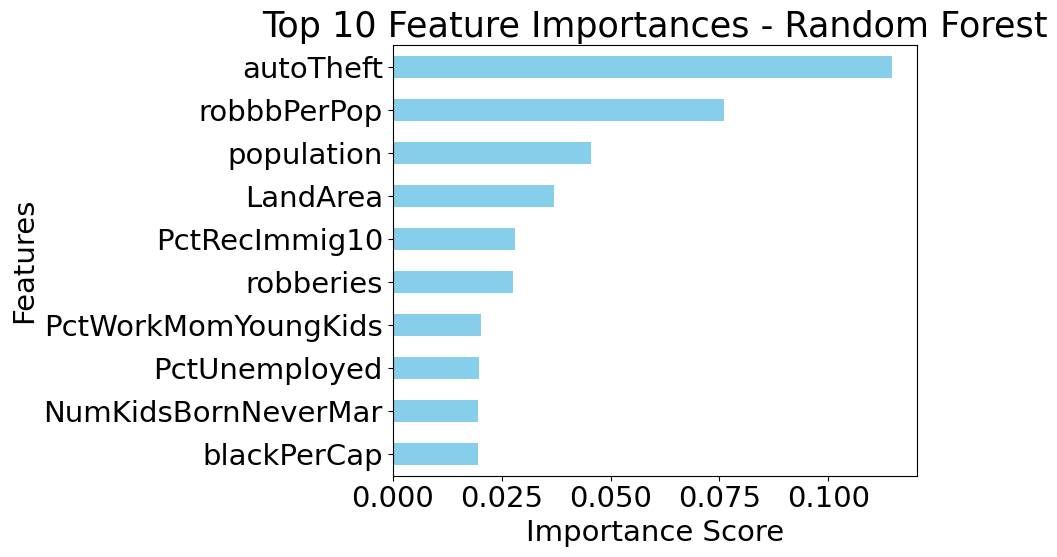

In [54]:
# Feature Importance (Using Random Forest)
feature_importances = pd.Series(xgb_classifier.feature_importances_, index=features.columns)
top_features = feature_importances.nlargest(10)
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


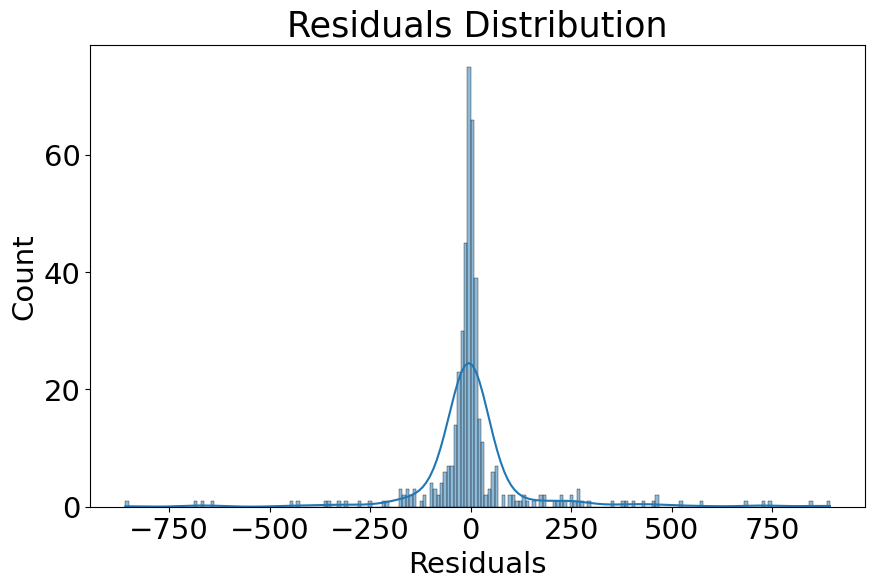

In [55]:
# Residual Analysis
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

In [56]:
# Summary Table for Model Comparisons
models_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'R2': [r2_baseline, linear_r2, dt_r2, rf_r2, gbm_r2, xgb_r2],
    'MSE': [mse_baseline, linear_mse, dt_mse, mse_rf, gbm_mse, xgb_mse],
    'RMSE': [rmse_baseline, linear_rmse, dt_rmse, rmse_rf, gbm_rmse, xgb_rmse]
})
models_comparison

NameError: name 'r2_baseline' is not defined

In [ ]:
# Comparison Table for Actual vs Predicted Values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
comparison_df.head()

,Actual,Predicted
1466,1083.85,1082.3409
1418,271.74,391.9290
581,130.95,129.0100
1517,841.00,965.8069
1231,301.00,278.9479
